In [1]:
# Notebook: Hypothesis H5 - Quality at Entry vs. Outcome

# --- Imports ---
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting H5 Analysis: Quality at Entry vs. Outcome ---")


--- Starting H5 Analysis: Quality at Entry vs. Outcome ---


In [2]:
# --- 1. Load CLEANED Data ---
cleaned_data_file = 'wbg_merged_cleaned_2.csv'
print(f"\nLoading cleaned data from: {cleaned_data_file}")
try:
    df_analysis = pd.read_csv(
        cleaned_data_file,
        header=1,
        delimiter=',',
        low_memory=False
    )
    print(f"Loaded cleaned data successfully. Shape: {df_analysis.shape}")
except FileNotFoundError: print(f"Error: File not found - {cleaned_data_file}. Run Part 1 first."); exit()
except Exception as e: print(f"Error loading {cleaned_data_file}: {e}"); exit()



Loading cleaned data from: wbg_merged_cleaned_2.csv
Loaded cleaned data successfully. Shape: (6098, 15)


In [3]:
# --- 2. Define Columns Needed ---
outcome_col = 'outcome' # Text outcome column (standardized from 'Outcome')
qat_entry_col = 'quality_at_entry' # QAT Entry column (standardized from 'Quality at Entry')
print(f"\nUsing columns: Outcome='{outcome_col}', QAT_Entry='{qat_entry_col}'")



Using columns: Outcome='outcome', QAT_Entry='quality_at_entry'


In [4]:
# --- 3. Preprocess Columns for H5 ---
required_cols = [outcome_col, qat_entry_col]
missing = [col for col in required_cols if col not in df_analysis.columns]
if missing: print(f"Error: Missing required columns: {missing}"); exit()

# Handle Missing Values for these specific columns
print(f"\nMissing values before H5 drop:\n{df_analysis[required_cols].isnull().sum()}")
df_analysis.dropna(subset=required_cols, inplace=True)
print(f"Shape after dropping NAs: {df_analysis.shape}")
if df_analysis.empty: print("Error: Data empty after NA drop."); exit()

# Binarize Outcome column (using text mapping from 'outcome')
print(f"\nPreprocessing outcome column '{outcome_col}'...")
df_analysis[outcome_col] = df_analysis[outcome_col].astype(str).str.strip()
unique_outcomes = df_analysis[outcome_col].unique()
print(f"Unique values found in '{outcome_col}': {unique_outcomes}")
satisfactory_ratings = ['Satisfactory', 'Moderately Satisfactory', 'Highly Satisfactory', 'SA', 'MS', 'HS']
unsatisfactory_ratings = ['Unsatisfactory', 'Moderately Unsatisfactory', 'Highly Unsatisfactory', 'U', 'MU', 'HU']
def map_text_outcome(txt):
    if txt in unsatisfactory_ratings: return 1
    elif txt in satisfactory_ratings: return 0
    else: return np.nan
df_analysis['outcome_binary'] = df_analysis[outcome_col].apply(map_text_outcome)
unmapped_count = df_analysis['outcome_binary'].isnull().sum();
if unmapped_count > 0:
    unmapped_vals = df_analysis[df_analysis['outcome_binary'].isnull()][outcome_col].unique()
    print(f"Warning: {unmapped_count} rows had unmapped outcome values ({unmapped_vals}). Dropping.")
    df_analysis.dropna(subset=['outcome_binary'], inplace=True)
df_analysis['outcome_binary'] = df_analysis['outcome_binary'].astype(int)
print("Created 'outcome_binary' (1=Unsat, 0=Sat).")
if df_analysis['outcome_binary'].nunique() < 2: print("Error: Only one outcome category present."); exit()
outcome_binary_col = 'outcome_binary' # Define for consistency

# Inspect and Preprocess Quality at Entry Column
print(f"\nPreprocessing Quality at Entry column '{qat_entry_col}'...")
df_analysis[qat_entry_col] = df_analysis[qat_entry_col].astype(str).str.strip()
unique_qat_entry = df_analysis[qat_entry_col].unique()
print(f"Unique values found in '{qat_entry_col}': {unique_qat_entry}")
print(f"Value counts for '{qat_entry_col}':\n{df_analysis[qat_entry_col].value_counts()}")
# Determine if Numeric or Categorical
is_numeric_qat = False; numeric_analysis_col_h5 = None
try:
    is_potential_numeric = df_analysis[qat_entry_col].str.match(r'^-?\d+(\.\d+)?$').all()
    if is_potential_numeric:
        qat_numeric_temp = pd.to_numeric(df_analysis[qat_entry_col], errors='coerce')
        if qat_numeric_temp.notnull().sum() / len(df_analysis[qat_entry_col].dropna()) > 0.9:
            is_numeric_qat = True; print(f"'{qat_entry_col}' appears NUMERIC.")
            df_analysis['qat_entry_numeric'] = qat_numeric_temp
            rows_before_num_drop = df_analysis.shape[0]
            df_analysis.dropna(subset=['qat_entry_numeric'], inplace=True)
            rows_after_num_drop = df_analysis.shape[0]
            if rows_before_num_drop > rows_after_num_drop: print(f"Dropped {rows_before_num_drop - rows_after_num_drop} rows where '{qat_entry_col}' couldn't be treated as numeric.")
            numeric_analysis_col_h5 = 'qat_entry_numeric'
            print(f"Unique numeric values in '{numeric_analysis_col_h5}': {df_analysis[numeric_analysis_col_h5].unique()}")
        else: print(f"'{qat_entry_col}' treated as CATEGORICAL/TEXT (numeric conversion failed for many).")
    else: print(f"'{qat_entry_col}' treated as CATEGORICAL/TEXT (values are not purely numeric strings).")
except Exception as e: print(f"Error during QAT numeric check, treating as CATEGORICAL. Error: {e}"); is_numeric_qat = False

analysis_col_h5 = numeric_analysis_col_h5 if is_numeric_qat else qat_entry_col
if analysis_col_h5 in df_analysis.columns and df_analysis[analysis_col_h5].nunique() < 2:
    print(f"Warning: '{analysis_col_h5}' has < 2 unique values after processing."); analysis_col_h5 = None
elif analysis_col_h5 not in df_analysis.columns:
    print(f"Error: Analysis column '{analysis_col_h5}' not found after processing."); analysis_col_h5 = None

print(f"Final data shape for H5 analysis: {df_analysis.shape}")



Missing values before H5 drop:
outcome               0
quality_at_entry    200
dtype: int64
Shape after dropping NAs: (5898, 15)

Preprocessing outcome column 'outcome'...
Unique values found in 'outcome': ['Moderately Satisfactory' 'Satisfactory' 'Moderately Unsatisfactory'
 'Unsatisfactory' 'Highly Satisfactory' 'Highly Unsatisfactory']
Created 'outcome_binary' (1=Unsat, 0=Sat).

Preprocessing Quality at Entry column 'quality_at_entry'...
Unique values found in 'quality_at_entry': ['Moderately Satisfactory' 'Moderately Unsatisfactory' 'Satisfactory'
 'Unsatisfactory' 'Highly Satisfactory' 'Highly Unsatisfactory']
Value counts for 'quality_at_entry':
quality_at_entry
Satisfactory                 2115
Moderately Satisfactory      1856
Moderately Unsatisfactory    1137
Unsatisfactory                607
Highly Satisfactory           146
Highly Unsatisfactory          37
Name: count, dtype: int64
'quality_at_entry' treated as CATEGORICAL/TEXT (values are not purely numeric strings).
Fina

In [5]:
# --- 4. Test Hypothesis H5 ---
print(f"\n--- Testing H5: Quality at Entry ({analysis_col_h5 or 'N/A'}) vs. Final Outcome ---")
alpha = 0.05
if analysis_col_h5:
    if is_numeric_qat: # Use T-test
        print("Performing T-test (numeric QAT Entry)...")
        q_sat = df_analysis[df_analysis[outcome_binary_col] == 0][analysis_col_h5]
        q_unsat = df_analysis[df_analysis[outcome_binary_col] == 1][analysis_col_h5]
        if len(q_sat) < 2 or len(q_unsat) < 2: print("Warning H5: Not enough data for t-test.")
        else:
            t_stat, p_val = stats.ttest_ind(q_unsat, q_sat, equal_var=False, nan_policy='omit')
            print(f"Mean QAT (Unsat, N={len(q_unsat)}): {q_unsat.mean():.2f}; Mean QAT (Sat, N={len(q_sat)}): {q_sat.mean():.2f}")
            print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4g}")
            if p_val < alpha: print(f"Result H5: Reject H0 (p < {alpha}). Significant difference in mean QAT rating."); print("  Interpretation:", "Unsat: HIGHER QAT." if t_stat > 0 else "Unsat: LOWER QAT.")
            else: print(f"Result H5: Fail to reject H0 (p >= {alpha}). No significant difference in mean QAT rating.")
            try: plt.figure(figsize=(8,6)); sns.boxplot(x=outcome_binary_col, y=analysis_col_h5, data=df_analysis); plt.title('QAT Rating by Final Outcome'); plt.xlabel('Outcome (0=Sat, 1=Unsat)'); plt.ylabel(f'QAT Rating ({analysis_col_h5})'); plt.xticks([0, 1], ['Satisfactory', 'Unsatisfactory']); plt.tight_layout(); plt.show()
            except Exception as e: print(f"Plot H5 Error: {e}")
    else: # Use Chi-squared test
        print("Performing Chi-Squared test (categorical QAT Entry)...")
        cont_table = pd.crosstab(df_analysis[analysis_col_h5], df_analysis[outcome_binary_col])
        if cont_table.shape[0] < 2 or cont_table.shape[1] < 2: print(f"Warning H5 ({analysis_col_h5}): Cont. table too small.")
        else:
            try:
                chi2, p_val, dof, exp_freq = stats.chi2_contingency(cont_table)
                print(f"Chi-Squared Stat: {chi2:.4f}, P-value: {p_val:.4g}, DoF: {dof}")
                low_freq = (exp_freq < 5).sum() if exp_freq is not None else -1
                if exp_freq is not None and exp_freq.size > 0: perc = (low_freq / exp_freq.size)*100; print(f"Warning H5 ({analysis_col_h5}): {low_freq} cells ({perc:.1f}%) < 5 expected freq.") if low_freq > 0 else print(f"Check H5 ({analysis_col_h5}): Expected freq assumption met.")
                else: print(f"Warning H5 ({analysis_col_h5}): Could not check expected freqs.")
                if p_val < alpha: print(f"Result H5: Reject H0 (p < {alpha}). Significant association."); cont_table['unsat%'] = cont_table[1]/(cont_table[0]+cont_table[1])*100; print(f"\nUnsat rates by {analysis_col_h5}:\n{cont_table.sort_values('unsat%', ascending=False)[['unsat%']]}") # Plot optional here
                else: print(f"Result H5: Fail to reject H0 (p >= {alpha}). No significant association.")
            except ValueError as ve: print(f"Error H5 ({analysis_col_h5}): Chi-Sq test failed: {ve}")
else: print(f"Skipping H5 test: QAT Entry column '{qat_entry_col}' not usable or available after preprocessing.")

print("\n--- H5 Analysis Complete ---")


--- Testing H5: Quality at Entry (quality_at_entry) vs. Final Outcome ---
Performing Chi-Squared test (categorical QAT Entry)...
Chi-Squared Stat: 2067.3380, P-value: 0, DoF: 5
Check H5 (quality_at_entry): Expected freq assumption met.
Result H5: Reject H0 (p < 0.05). Significant association.

Unsat rates by quality_at_entry:
outcome_binary                unsat%
quality_at_entry                    
Highly Unsatisfactory      91.891892
Unsatisfactory             75.288303
Moderately Unsatisfactory  54.617414
Moderately Satisfactory    13.739224
Satisfactory                4.869976
Highly Satisfactory         1.369863

--- H5 Analysis Complete ---


In [6]:
# Notebook: Visualization for H5 - Quality at Entry vs. Outcome
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

print("--- Generating Visualization for H5: Quality at Entry vs. Outcome ---")


--- Generating Visualization for H5: Quality at Entry vs. Outcome ---


In [7]:
# --- 1. Load CLEANED Data ---
# Ensure this filename matches the output from the Part 1 script
cleaned_data_file = 'wbg_merged_cleaned_2.csv'
print(f"\nLoading cleaned data from: {cleaned_data_file}")
try:
    df_analysis = pd.read_csv(
        cleaned_data_file,
        header=1,
        delimiter=',',
        low_memory=False
    )
    print(f"Loaded cleaned data successfully. Shape: {df_analysis.shape}")
except FileNotFoundError: print(f"Error: File not found - {cleaned_data_file}. Run Part 1 first."); exit()
except Exception as e: print(f"Error loading {cleaned_data_file}: {e}"); exit()



Loading cleaned data from: wbg_merged_cleaned_2.csv
Loaded cleaned data successfully. Shape: (6098, 15)


In [8]:
# --- 2. Define Columns Needed ---
outcome_col = 'outcome'           # Original text outcome column name
qat_entry_col = 'quality_at_entry'
outcome_binary_col = 'outcome_binary'
print(f"\nUsing columns: Text Outcome='{outcome_col}', QAT_Entry='{qat_entry_col}'")
print(f"Will create binary outcome column named: '{outcome_binary_col}'")



Using columns: Text Outcome='outcome', QAT_Entry='quality_at_entry'
Will create binary outcome column named: 'outcome_binary'


In [9]:
# --- 3. Verify and Preprocess Columns ---
required_cols = [outcome_col, qat_entry_col]
missing = [col for col in required_cols if col not in df_analysis.columns]
if missing:
    print(f"\nError: Missing required columns: {missing}")
    print(f"Available columns are: {df_analysis.columns.tolist()}")
    exit()

# Handle Missing Values for these specific columns FIRST
print(f"\nMissing values before NA drop:\n{df_analysis[required_cols].isnull().sum()}")
df_analysis.dropna(subset=required_cols, inplace=True)
print(f"Shape after dropping NAs for required columns: {df_analysis.shape}")
if df_analysis.empty: print("Error: Data empty after initial NA drop."); exit()

# Ensure QAT Entry is string (for grouping)
df_analysis[qat_entry_col] = df_analysis[qat_entry_col].astype(str).str.strip()

# --- Binarize Outcome column (using text mapping from 'outcome') ---
print(f"\nPreprocessing outcome column '{outcome_col}' to create '{outcome_binary_col}'...")
df_analysis[outcome_col] = df_analysis[outcome_col].astype(str).str.strip()
unique_outcomes = df_analysis[outcome_col].unique()
print(f"Unique values found in '{outcome_col}': {unique_outcomes}")
# *** REVIEW & ADJUST MAPPING LISTS IF NEEDED ***
satisfactory_ratings = ['Satisfactory', 'Moderately Satisfactory', 'Highly Satisfactory', 'SA', 'MS', 'HS']
unsatisfactory_ratings = ['Unsatisfactory', 'Moderately Unsatisfactory', 'Highly Unsatisfactory', 'U', 'MU', 'HU']
def map_text_outcome(txt):
    if txt in unsatisfactory_ratings: return 1
    elif txt in satisfactory_ratings: return 0
    else: return np.nan
# Create the column using the name defined in Step 2 ('outcome_binary')
df_analysis[outcome_binary_col] = df_analysis[outcome_col].apply(map_text_outcome)
unmapped_count = df_analysis[outcome_binary_col].isnull().sum();
if unmapped_count > 0:
    unmapped_vals = df_analysis[df_analysis[outcome_binary_col].isnull()][outcome_col].unique()
    print(f"Warning: {unmapped_count} rows had unmapped outcome values ({unmapped_vals}). Dropping.")
    df_analysis.dropna(subset=[outcome_binary_col], inplace=True) # Drop rows that couldn't be mapped

if df_analysis.empty: print("Error: Data empty after dropping unmapped outcomes."); exit()

df_analysis[outcome_binary_col] = df_analysis[outcome_binary_col].astype(int)
print(f"Created '{outcome_binary_col}'.")
if df_analysis[outcome_binary_col].nunique() < 2: print("Error: Only one outcome category present after mapping."); exit()
# --- (End of Preprocessing) ---



Missing values before NA drop:
outcome               0
quality_at_entry    200
dtype: int64
Shape after dropping NAs for required columns: (5898, 15)

Preprocessing outcome column 'outcome' to create 'outcome_binary'...
Unique values found in 'outcome': ['Moderately Satisfactory' 'Satisfactory' 'Moderately Unsatisfactory'
 'Unsatisfactory' 'Highly Satisfactory' 'Highly Unsatisfactory']
Created 'outcome_binary'.


In [10]:
# --- 4. Calculate Statistics per QAT Entry Category ---
print("\nCalculating statistics per QAT Entry category...")
qat_summary = df_analysis.groupby(qat_entry_col)[outcome_binary_col].agg(
    total_projects='count',
    unsatisfactory_rate='mean'
).reset_index()
qat_summary['unsatisfactory_pct'] = qat_summary['unsatisfactory_rate'] * 100
print(f"Generated summary for {len(qat_summary)} QAT categories.")



Calculating statistics per QAT Entry category...
Generated summary for 6 QAT categories.


In [11]:
# --- 5. Define Logical Order and Sort ---
qat_order = [
    'Highly Unsatisfactory',
    'Unsatisfactory',
    'Moderately Unsatisfactory',
    'Moderately Satisfactory',
    'Satisfactory',
    'Highly Satisfactory'
]
# Filter summary to only include expected categories and set order
qat_summary[qat_entry_col] = pd.Categorical(qat_summary[qat_entry_col], categories=qat_order, ordered=True)
# Remove any categories not in our defined order (e.g., if 'Other' existed)
qat_summary.dropna(subset=[qat_entry_col], inplace=True)
# Sort based on the defined categorical order
qat_summary_sorted = qat_summary.sort_values(qat_entry_col)

print("\nSummary table sorted by QAT rating:")
print(qat_summary_sorted)


Summary table sorted by QAT rating:
            quality_at_entry  total_projects  unsatisfactory_rate  \
1      Highly Unsatisfactory              37             0.918919   
5             Unsatisfactory             607             0.752883   
3  Moderately Unsatisfactory            1137             0.546174   
2    Moderately Satisfactory            1856             0.137392   
4               Satisfactory            2115             0.048700   
0        Highly Satisfactory             146             0.013699   

   unsatisfactory_pct  
1           91.891892  
5           75.288303  
3           54.617414  
2           13.739224  
4            4.869976  
0            1.369863  



Generating sorted bar chart...


<ipython-input-12-a981325ef975>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


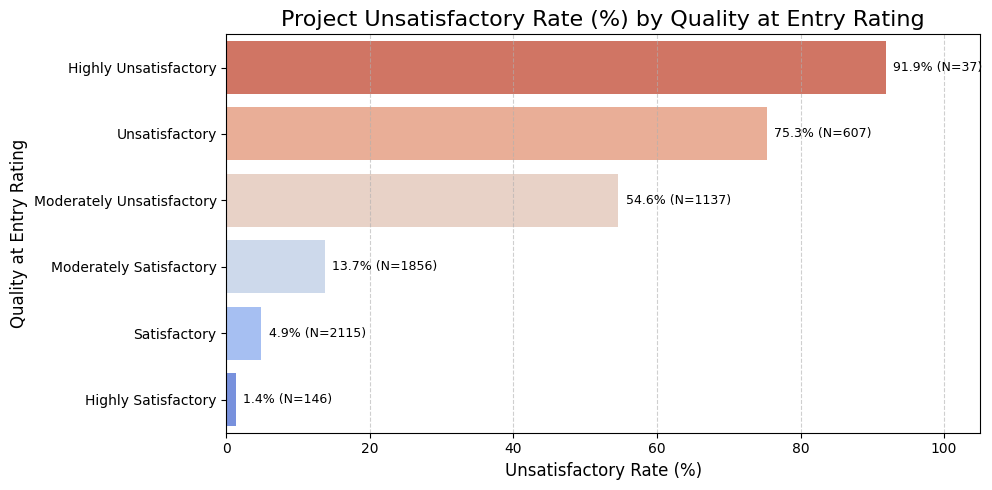


--- H5 Visualization Complete ---


In [12]:
# --- 6. Create Sorted Horizontal Bar Chart ---
print("\nGenerating sorted bar chart...")
# Adjust figure height based on the number of practices
num_categories = len(qat_summary_sorted)
plt.figure(figsize=(10, max(5, num_categories * 0.6))) # Adjust height

# Create bar plot with QAT categories on y-axis
barplot = sns.barplot(
    data=qat_summary_sorted,
    y=qat_entry_col,          # QAT categories on vertical axis
    x='unsatisfactory_pct', # Percentage on horizontal axis
    order=qat_order,         # Use the defined logical order
    palette='coolwarm_r'      # Example: Reversed coolwarm (red=high, blue=low)
)

# Add Titles and Labels
plt.title('Project Unsatisfactory Rate (%) by Quality at Entry Rating', fontsize=16)
plt.xlabel('Unsatisfactory Rate (%)', fontsize=12)
plt.ylabel('Quality at Entry Rating', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) # Adjust font size if needed

# Add text labels for percentage and N (total projects)
for index, row in qat_summary_sorted.iterrows():
    # Find the correct y-position based on the sorted category order
    # Need to handle potential missing categories from qat_order if they weren't in data
    try:
        y_pos = qat_order.index(row[qat_entry_col])
        plt.text(row['unsatisfactory_pct'] + 1, # Position text slightly right of bar end
                 y_pos,                         # Use index corresponding to category order
                 f"{row['unsatisfactory_pct']:.1f}% (N={row['total_projects']})",
                 va='center',                   # Vertical alignment
                 fontsize=9)                    # Adjust font size
    except ValueError: # Category was not in the expected qat_order list
         print(f"Could not find position for label: {row[qat_entry_col]}")

plt.xlim(0, 105) # Set x-axis limit to 105% to ensure space for labels
plt.grid(axis='x', linestyle='--', alpha=0.6) # Add vertical grid lines
plt.tight_layout()
plt.show()

print("\n--- H5 Visualization Complete ---")
